#Data prep

Data prep includes:
- divide main data into train and test

In [129]:
import pandas as pd

# The master data is the result from clustering part
# Check out KMeans_customer_segment (1).ipynb for code
# and README_Clustering_segmentation.md for detailed description

df_churn = pd.read_csv(r'/content/churn_data_final.csv')
df_churn.head(2)

# Clean the data
df_churn.drop(columns = ['P1M', 'P3M'], inplace = True)
df_churn.drop_duplicates(inplace = True)

In [130]:
# Divide data into main and test set
# Create a test set by taking out 10% of current data
hold_out_id = df_churn.sample(frac=0.1, random_state=40).index

# Two sets created
df_teaching = df_churn.loc[~df_churn.index.isin(hold_out_id)]
df_testing = df_churn.loc[df_churn.index.isin(hold_out_id)]

# Churn prediction

## Train test split
- To prevent data leakage, I'll seperate df_teaching from testing
- Also, I'll split the df_teeaching beforehand so that data might not leak to validation set
- I use OneHotEncoder after that to:
  + Not allow data leaking to df_testing
  + OneHotEncoding coudl adapt better than get_dummies in case of strange value
  + For example: if train set has companion_friend, and companion_colleague but test set only has companion_other, OneHotEncoder still works but get_dummies not

In [131]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Data set up
# df_teaching
X_train, X_val, y_train, y_val = train_test_split(
    df_teaching.drop(columns="churn"),
    df_teaching[['ID', "churn"]],
    test_size=0.2,
    random_state=42
)
# df_testing
X_test = df_testing.drop(columns='churn')
y_test = df_testing[['ID', 'churn']]

# Encoding using OneHotEncoder
# Cols
categorical_cols = ['Occupation#group', 'Comprehension', 'Companion#group', 'NeedstateGroup', 'segment']
numerical_cols = ['Age', 'MPI_Mean_Use', 'Fre#visit', 'Spending', 'PPA', 'NPS#P3M']

# Encoder set up
# handle_unknown='ignore' will prevent errors if a category appears in val/test but not in train
# Use only 1 encoder to prevent leakage
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit the encoder on the training data's categorical columns
encoder.fit(X_train[categorical_cols])
encoded_cols = encoder.get_feature_names_out(categorical_cols)

# Transform the categorical columns for all three datasets
X_train_encoded = pd.DataFrame(encoder.transform(X_train[categorical_cols]), columns=encoded_cols, index=X_train.index)
X_val_encoded = pd.DataFrame(encoder.transform(X_val[categorical_cols]), columns=encoded_cols, index=X_val.index)
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_cols]), columns=encoded_cols, index=X_test.index)



# Recombine Encoded and Numerical Columns
X_train_full = pd.concat([X_train_encoded, X_train[numerical_cols + ['ID']]], axis=1)
X_val_full = pd.concat([X_val_encoded, X_val[numerical_cols + ['ID']]], axis=1)
X_test_full = pd.concat([X_test_encoded, X_test[numerical_cols + ['ID']]], axis=1)


# Group by ID
# X vars
X_train_grouped = X_train_full.groupby('ID').max().reset_index()
X_val_grouped = X_val_full.groupby('ID').max().reset_index()
X_test_grouped = X_test_full.groupby('ID').max().reset_index()

# Y vars
y_train_grouped = y_train[y_train['ID'].isin(X_train_grouped['ID'])].groupby('ID').max().reset_index()
y_val_grouped = y_val[y_val['ID'].isin(X_val_grouped['ID'])].groupby('ID').max().reset_index()
y_test_grouped = y_test[y_test['ID'].isin(X_test_grouped['ID'])].groupby('ID').max().reset_index()


# Drop Redundant ID Column
# The ID is no longer needed as a feature for the model
X_train_final = X_train_grouped.drop(columns='ID')
X_val_final = X_val_grouped.drop(columns='ID')
X_test_final = X_test_grouped.drop(columns='ID')

y_train = y_train_grouped.drop(columns='ID')
y_val = y_val_grouped.drop(columns='ID')
y_test = y_test_grouped.drop(columns='ID')


# Standardize vars
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_final),
    columns=X_train_final.columns
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_final),
    columns=X_val_final.columns
)

# Use the same scaler for testing data
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_final),
    columns=X_test_final.columns
)


## Cross validation for algorithm choosing

Since I just want to evaluate the algorithm, I used the teaching set and use get_dummies only for ease of use

In [142]:
import pandas as pd
import numpy as np
import statistics as stat
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    AdaBoostClassifier, BaggingClassifier
)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
)

# Data setup
df_encoded = df_teaching.copy()

# Cols
id_col = 'ID'
target_col = 'churn'
numeric_cols = ['Age', 'MPI_Mean_Use', 'Fre#visit', 'Spending', 'PPA', 'NPS#P3M']
cat_cols = [
    'Occupation#group', 'Comprehension', 'Companion#group',
    'NeedstateGroup', 'segment'
]

# One-hot encoding.
df_encoded = pd.get_dummies(df_teaching, columns=cat_cols)

# Create a dictionary of aggregation rules for the groupby operation
agg_rules = {col: 'mean' for col in numeric_cols}
dummy_cols = [col for col in df_encoded.columns if col not in [id_col, target_col] + numeric_cols]
agg_rules.update({col: 'max' for col in dummy_cols})
agg_rules[target_col] = 'first'

# Group by ID and apply the aggregation rules in one step
df_agg = df_encoded.groupby(id_col).agg(agg_rules).reset_index()


# The `churn` column is the target (y)
y_final = df_agg[target_col]
# The rest of the columns, except for the ID, are features (X)
X_final = df_agg.drop(columns=[id_col, target_col])



# Tested algorithms
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Bagging": BaggingClassifier(),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(reg_param=0.1)

}

# Evaluate Each Classifier
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in classifiers.items():
    # Create a pipeline that first scales the data, then fits the classifier
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])

    # Perform cross-validation and store the list of scores
    try:
        cv_results = cross_val_score(pipe, X_final, y_final, cv=cv, scoring='accuracy')
        roc_auc = cross_val_score(pipe, X_final, y_final, cv=cv, scoring='roc_auc')
        preci = cross_val_score(pipe, X_final, y_final, cv=cv, scoring='precision')
        recall = cross_val_score(pipe, X_final, y_final, cv=cv, scoring='recall')

        results[name] = {'Accuracy': stat.mean(cv_results),
                         'ROC_AUC': stat.mean(roc_auc),
                         'Precision': stat.mean(preci),
                         'Recall': stat.mean(recall)}

    except Exception as e:
        print(f"Could not evaluate {name}. Error: {e}")
        break


# Results
df_results = pd.DataFrame.from_dict(results, orient='index')

df_results = df_results.round(4)

df_results.sort_values(by='Accuracy', ascending = False)

,Accuracy,ROC_AUC,Precision,Recall
Gradient Boosting,0.8690,0.9112,0.7829,0.6250
Random Forest,0.8656,0.9031,0.7840,0.5998
Bagging,0.8570,0.8716,0.7639,0.6214
AdaBoost,0.8356,0.8862,0.7319,0.4951
Logistic Regression,0.8279,0.8627,0.6963,0.4928
SVM,0.8216,0.8540,0.7507,0.3750
Decision Tree,0.8067,0.7428,0.5887,0.6190
LDA,0.8041,0.8208,0.7250,0.2884
KNN,0.7638,0.7283,0.5121,0.3125
QDA,0.5742,0.8036,0.3488,0.9026


The result shows that gradient boosting outperforms other algorithm in terms of:
- Accuracy: ~87%  => predict correctly
- ROC_AUC_score: ~91%  => percent of prediction not random


In [133]:
# Compare against basseline (guess all 0 - no churn at all)
from sklearn.metrics import accuracy_score, roc_auc_score
print(f' Accuracy: {accuracy_score(y_final, np.zeros_like(y_final)):.4f} and ROC_AUC score: {roc_auc_score(y_final, np.zeros_like(y_final)):.4f}')

 Accuracy: 0.7621 and ROC_AUC score: 0.5000


Gradient Boosting is the best choice:
- It has highest Accuracy, higher than blind guessing every customers as no churn
- It could balance between recall and precision
- ROC_AUC means model will assign higher value for churn (1) than for retain (0) about 91% of the time.

 ## Run Gradient Boosting on main data
 I used data splitted from the section 1: train test split

Hyper-param fine-tuning

In [134]:
# Hyper-param fine-tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

# Fine-tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [1, 3, 5, 7, 9]
}

grid = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best parameters:", grid.best_params_)

Best parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300}


Model fitting

In [135]:
# Fit the model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Initialize model
model_main = GradientBoostingClassifier(n_estimators=300, learning_rate=0.01, max_depth=7, random_state=42)

# Fit the model on training data
model_main.fit(X_train_scaled, y_train)

# Predict on validation data
y_pred = model_main.predict(X_val_scaled)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)

# Print results
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")


Accuracy : 0.9247
Precision: 0.8728
Recall   : 0.7848


Testing the model using hold-out set

In [136]:
# Fit into main_model
y_test_pred = model_main.predict(X_test_scaled)

# Calculate metrics
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)

# Print results
print(f"Accuracy : {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall   : {recall_test:.4f}")

Accuracy : 0.9184
Precision: 0.8655
Recall   : 0.7943


- The model performs well on testing sets
- All of accuracy, precision and recall are high, quite close to the validation set


## Feature importance

To evaluate which factors most affecting whether a customer churn or not, I use Shapp

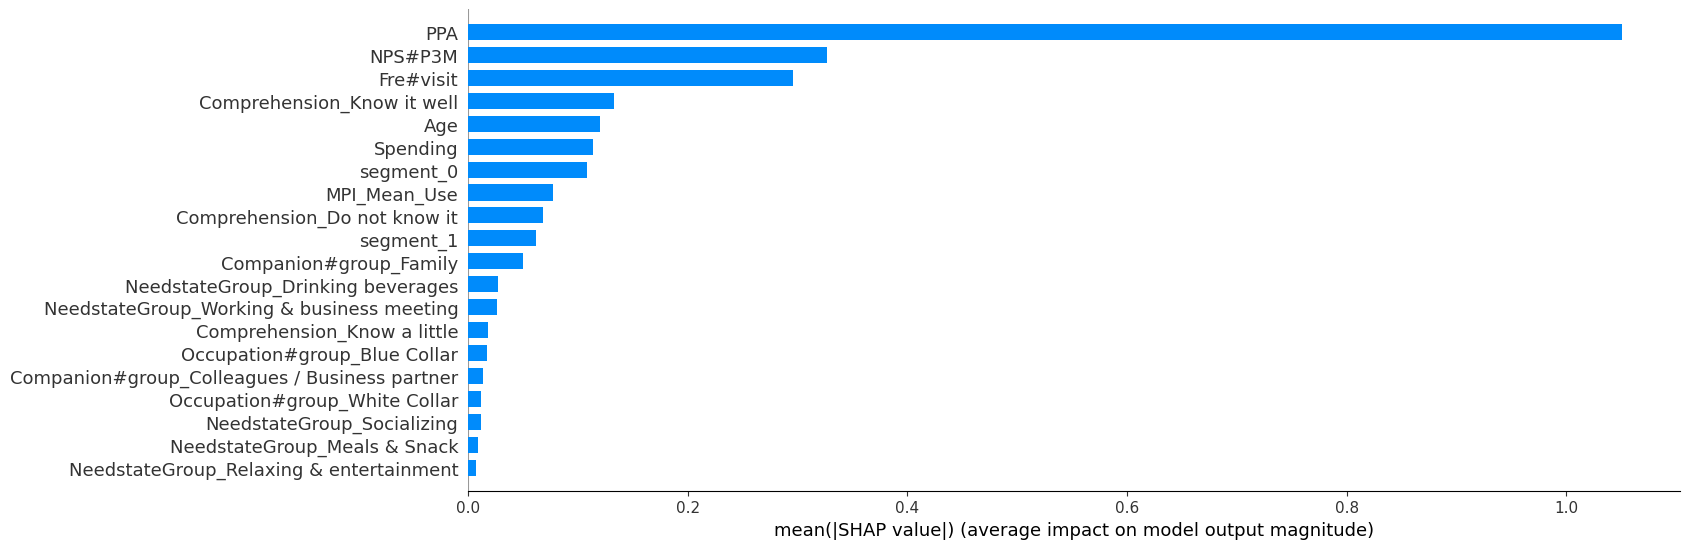

In [139]:
import shap
shap_value = shap.Explainer(model_main).shap_values(X_val_scaled)
shap.summary_plot(shap_value, X_val_scaled, plot_type='bar', plot_size=(17,5.6))

The chart shows PPA to be the outstandingly important feature making someone either 1 or 0:
- Therefore, Highland should pay close attention to both Spending and Fre#Visit of customers to determine if they are churn or not
- Especially, they should pay attention to Fre#visit over Spending because as shown in chart, Fre#visit is the second most important feature

# Final recommendation

Highlands Coffee could:
- Use my model to predict churn accurately about 91% of the time
- The model could predict true churn correctly at about 87% of the time while it could also cover about 78% of churn cases.

In the future:
- Highlands coffee should focus especially on PPA (spend per visit) of customers to determine churns
- PPA is made of Spending and Visit frequency. And as the Shapp chart shows Fre#visit is more important than Spending in predicting churn, they should prioritize looking at "Visit frequency" when comparing between customers of same PPA.